In [10]:
# Import used packages
%matplotlib notebook
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from matplotlib import animation
import networkx as nx
import random
import copy

# Implementation of SEIR model
## Model
The SEIR model describes the propagation of a disease in 4 stages: susceptible, exposed, infected and recovered. Each state has different properties. At the start most people are susceptible, these can get exposed when in contact with someone who is infected. Exposed people cannot infect other people yet. They will get infectious after some time, dependent on the incubation period. Infected people can recover, when recovered they are immune to the dissease.
## Parameters
We used $\beta$ as the probability to become exposed when in contact with 1 infected person, $\delta$ is the probability of becoming infected when exposed and $\gamma$ is the probability to recover when infected.
## Datastructure
To contain all the data, we used a dictionairy 'Network'. This contains the following keys: <br>
- 'nodes': int, the amount of nodes <br>
- 'pos': list, list of lists of length 2 containing the x and y positions of the nodes <br>
- 'links': list, list of lists containing the numbers corresponding to the nodes connected to the i'th node <br>
- 'currentState': list, list of the stage of the i'th node at the current timestep <br>
- 'currentColor': list, list of the color of the i'th node at the current timestep <br>
- 'newState': list, list of the stage of the i'th node at the next timestep <br>
- 'dataStates': list (of lists), list of all the lists passing 'currentState' <br>
- 'dataColors': list (of lists), list of all the lists passing 'currentColor' <br>
- 'time': list, list of consecutive integers representing the timesteps <br>
- 'S': list, list of how many nodes are in the susceptible stage at the i'th timestep <br>
- 'E': list, list of how many nodes are in the exposed stage at the i'th timestep <br>
- 'I': list, list of how many nodes are in the infected stage at the i'th timestep <br>
- 'R': list, list of how many nodes are in the recovered stage at the i'th timestep <br>
- 'socialDistanceTimestep': int, the timestep at which social distancing occurs (defaults to np.nan)

In [5]:
# Declare global parameters
class ST_base():
    pass

ST = ST_base()
ST.S = 0
ST.E = 1
ST.I = 2
ST.R = 3

class ST_color():
    pass

STcolor = ST_color()
STcolor.S = 'palegreen'
STcolor.E = 'orchid'
STcolor.I = 'tomato'
STcolor.R = 'deepskyblue'

class PL_attributes():
    pass

PL = PL_attributes()
PL.edgeColor = 'grey'
PL.edgeAlpha = 0.4
PL.nodeSize = 80
PL.zoom = 5

In [73]:
def createnetwork(nodes, k, p):
    Network = {'nodes': nodes, 'links': nx.watts_strogatz_graph(nodes, k, p)}
    Network['pos'] =  nx.spring_layout(Network['links'])
    return Network

In [40]:
def start(Network, exposedPerc, local):
    Network['currentState'] = [ST.S]*Network['nodes']
    Network['currentColor'] = [STcolor.S]*Network['nodes']
    Network['socialDistanceTimestep'] = np.nan
    exposedNumber = exposedPerc*Network['nodes']
    if local:
        exposed = startperc(Network, exposedNumber)
    else:
        exposed = []
        i = 0
        while i < exposedNumber:
            randomN = random.randint(0, Network['nodes'] - 1)
            if randomN not in exposed:
                exposed.append(randomN)
                i += 1
    for i in exposed:
            Network['currentState'][i] = ST.E
            Network['currentColor'][i] = STcolor.E
            
    return Network

def startperc(Network, exposedNumber):
    exposed = [random.randint(0, Network['nodes'] - 1)]
    while len(exposed) < exposedNumber:
        exposedNew = exposed.copy()
        for i in exposedNew:
            for connectedToI in Network['links'][i]:
                if len(exposedNew) < exposedNumber:
                    if connectedToI not in exposedNew:
                        exposedNew.append(connectedToI)
                else:
                    return exposedNew
        if len(exposed) == len(exposedNew):
            return startperc(Network, exposedNumber)
        exposed = exposedNew
    
    return exposed

In [229]:
# Create list of the next state after 1 timestep
def updateSEIR(Network, beta, delta, gamma):
    Network['newState'] = []
    for i in range(Network['nodes']):
        if Network['currentState'][i] == ST.S:
            Phealthy = 1
            for j in Network['links'][i]:
                if Network['currentState'][j] == ST.I:
                    Phealthy *= (1 - beta)
            PSick = 1 - Phealthy
            randomN = random.uniform(0, 1)
            if randomN < PSick:
                Network['newState'].append(ST.E)
                Network['currentColor'][i] = STcolor.E
            else:
                Network['newState'].append(Network['currentState'][i])
        elif Network['currentState'][i] == ST.E:
            randomN = random.uniform(0, 1)
            if randomN < delta:
                Network['newState'].append(ST.I)
                Network['currentColor'][i] = STcolor.I
            else:
                Network['newState'].append(Network['currentState'][i])
        elif Network['currentState'][i] == ST.I:
            randomN = random.uniform(0, 1)
            if randomN < gamma:
                Network['newState'].append(ST.R)
                Network['currentColor'][i] = STcolor.R
            else:
                Network['newState'].append(Network['currentState'][i])
        else:
            Network['newState'].append(Network['currentState'][i])
    Network['currentState'] = Network['newState']
    
    return Network

# Creates list holding all information of the situation in every time step 
# and plots color-coded network of every timestep if plotNetwork is True
def spreaddiseaseSEIR(Network, timesteps, beta, delta, gamma, socialDistance = False, socialDistancePerc = 0, removePerc = 0, split = False):
    Network['dataStates'] = [Network['currentState']]
    Network['dataColors'] = [Network['currentColor'].copy()]
    Network = countingSEIR(Network)
    
    for i in range(timesteps):
        if socialDistance:
            if Network['I'][-1] >= Network['nodes']*socialDistancePerc:
                if split:
                    originalNetwork = copy.deepcopy(Network)
                Network['links'] = removeedges(Network['links'], removePerc)
                Network['socialDistanceTimestep'] = i
                socialDistance = False
        
        Network = updateSEIR(Network, beta, delta, gamma)
        Network['dataStates'].append(Network['currentState'])
        Network['dataColors'].append(Network['currentColor'].copy())
        Network = countingSEIR(Network)
    
    if Network['socialDistanceTimestep'] != np.nan and split:
        for i in range(Network['socialDistanceTimestep'], timesteps):
            originalNetwork = updateSEIR(originalNetwork, beta, delta, gamma)
            originalNetwork['dataStates'].append(originalNetwork['currentState'])
            originalNetwork['dataColors'].append(originalNetwork['currentColor'].copy())
            originalNetwork = countingSEIR(originalNetwork)
        
    if split:
        return Network, originalNetwork
    else:
        return Network

# Count the amount of people in each state for every timestep
def countingSEIR(Network):
    counting = np.bincount(Network['currentState'], minlength = 4)
    Network['S'].append(counting[ST.S])
    Network['E'].append(counting[ST.E])
    Network['I'].append(counting[ST.I])
    Network['R'].append(counting[ST.R])
        
    return Network

# Executes all the functions above 
# and plots the evolution in all states with respect to time if plotStates == True
def everythingSEIR(Network, timesteps, beta, delta, gamma, plotStates = False, socialDistance = False, socialDistancePerc = 0, removePerc = 0, split= False):
    Network['time'] = np.arange(0, timesteps + 1, 1)
    Network['S'] = []
    Network['E'] = []
    Network['I'] = []
    Network['R'] = []
    
    if split:
        Network, originalNetwork = spreaddiseaseSEIR(Network, timesteps, beta, delta, gamma, socialDistance, socialDistancePerc, removePerc, split)
    else:
        Network = spreaddiseaseSEIR(Network, timesteps, beta, delta, gamma, socialDistance, socialDistancePerc, removePerc)
        
    if plotStates:
        if split:
            figData, (axData1, axData2) = plt.subplots(nrows= 1, ncols= 2, figsize = [2*PL.zoom, PL.zoom])
            
            axData1.plot(originalNetwork['time'], originalNetwork['S'], label = 'S', color= STcolor.S)
            axData1.plot(originalNetwork['time'], originalNetwork['E'], label = 'E', color= STcolor.E)
            axData1.plot(originalNetwork['time'], originalNetwork['I'], label = 'I', color= STcolor.I)
            axData1.plot(originalNetwork['time'], originalNetwork['R'], label = 'R', color= STcolor.R)
            
            axData1.legend(fontsize= 12)
            axData1.set_ylim(0, nodes)
            axData1.set_xlim(0, timesteps)
            axData1.tick_params(axis= 'both', which= 'major', labelsize= 14)
            axData1.grid()

            axData2.plot(Network['time'], Network['S'], label = 'S', color= STcolor.S)
            axData2.plot(Network['time'], Network['E'], label = 'E', color= STcolor.E)
            axData2.plot(Network['time'], Network['I'], label = 'I', color= STcolor.I)
            axData2.plot(Network['time'], Network['R'], label = 'R', color= STcolor.R)
            axData2.axvline(Network['socialDistanceTimestep'])

            axData2.legend(fontsize= 12)
            axData2.set_ylim(0, nodes)
            axData2.set_xlim(0, timesteps)
            axData2.tick_params(axis= 'both', which= 'major', labelsize= 14)
            axData2.grid()
            plt.show()
            
            
        
        else:
            figData = plt.figure()

            plt.plot(Network['time'], Network['S'], label = 'S', color= STcolor.S)
            plt.plot(Network['time'], Network['E'], label = 'E', color= STcolor.E)
            plt.plot(Network['time'], Network['I'], label = 'I', color= STcolor.I)
            plt.plot(Network['time'], Network['R'], label = 'R', color= STcolor.R)
            plt.axvline(Network['socialDistanceTimestep'])

            plt.title('', size= 20)
            plt.ylabel('', size= 20)
            plt.xlabel('', size= 20)
            plt.legend(fontsize= 12)
            plt.ylim(0, nodes)
            plt.xlim(0, timesteps)
            plt.tick_params(axis= 'both', which= 'major', labelsize= 14)
            plt.grid()

            plt.show()
        
        
    if split:
        return Network, originalNetwork
    else:
        return Network

# Averages over N different networks and evolutions of disseasespreading
# and plots the average evolution of all states if plotAverage == True
def averageSEIR(nodes, k, p, exposedPerc, timesteps, local, beta, delta, gamma, N, plotAverage, socialDistance= False, socialDistancePerc = 0, removePerc = 0, split= False):
    if split:
        averageS = np.zeros(timesteps + 1)
        averageE = np.zeros(timesteps + 1)
        averageI = np.zeros(timesteps + 1)
        averageR = np.zeros(timesteps + 1)
        averageOriginalS = np.zeros(timesteps + 1)
        averageOriginalE = np.zeros(timesteps + 1)
        averageOriginalI = np.zeros(timesteps + 1)
        averageOriginalR = np.zeros(timesteps + 1)
        averageSocialDistanceTimestep = 0
        for i in range(N):
            Network = createnetwork(nodes, k, p)
            Network = start(Network, exposedPerc, local)
            Network, originalNetwork = everythingSEIR(Network, timesteps, beta, delta, gamma, plotStates= False, socialDistance= socialDistance, socialDistancePerc= socialDistancePerc, removePerc= removePerc, split= split)
            averageS += Network['S']
            averageE += Network['E']
            averageI += Network['I']
            averageR += Network['R']
            averageOriginalS += originalNetwork['S']
            averageOriginalE += originalNetwork['E']
            averageOriginalI += originalNetwork['I']
            averageOriginalR += originalNetwork['R']
            averageSocialDistanceTimestep += Network['socialDistanceTimestep']

        averageS = averageS/N
        averageE = averageE/N
        averageI = averageI/N
        averageR = averageR/N
        averageOriginalS = averageOriginalS/N
        averageOriginalE = averageOriginalE/N
        averageOriginalI = averageOriginalI/N
        averageOriginalR = averageOriginalR/N
        averageSocialDistanceTimestep = averageSocialDistanceTimestep/N
        
        if plotAverage:
            figData, (axData1, axData2) = plt.subplots(nrows= 1, ncols= 2, figsize = [2*PL.zoom, PL.zoom])
            
            axData1.plot(originalNetwork['time'], averageOriginalS, label = 'S', color= STcolor.S)
            axData1.plot(originalNetwork['time'], averageOriginalE, label = 'E', color= STcolor.E)
            axData1.plot(originalNetwork['time'], averageOriginalI, label = 'I', color= STcolor.I)
            axData1.plot(originalNetwork['time'], averageOriginalR, label = 'R', color= STcolor.R)
            
            axData1.legend(fontsize= 12)
            axData1.set_ylim(0, nodes)
            axData1.set_xlim(0, timesteps)
            axData1.tick_params(axis= 'both', which= 'major', labelsize= 14)
            axData1.grid()

            axData2.plot(originalNetwork['time'], averageS, label = 'S', color= STcolor.S)
            axData2.plot(originalNetwork['time'], averageE, label = 'E', color= STcolor.E)
            axData2.plot(originalNetwork['time'], averageI, label = 'I', color= STcolor.I)
            axData2.plot(originalNetwork['time'], averageR, label = 'R', color= STcolor.R)
            axData2.axvline(averageSocialDistanceTimestep)
            
            axData2.legend(fontsize= 12)
            axData2.set_ylim(0, nodes)
            axData2.set_xlim(0, timesteps)
            axData2.tick_params(axis= 'both', which= 'major', labelsize= 14)
            axData2.grid()
            
            plt.show()
            
        return averageS, averageE, averageI, averageR, averageOriginalS, averageOriginalE, averageOriginalI, averageOriginalR, averageSocialDistanceTimestep
    
    else:
        averageS = np.zeros(timesteps + 1)
        averageE = np.zeros(timesteps + 1)
        averageI = np.zeros(timesteps + 1)
        averageR = np.zeros(timesteps + 1)
        
        for i in range(N):
            Network = createnetwork(nodes, k, p)
            Network = start(Network, exposedPerc, local)
            Network = everythingSEIR(Network, timesteps, beta, delta, gamma, plotStates= False, socialDistance= socialDistance, socialDistancePerc= socialDistancePerc, removePerc= removePerc, split= split)
            averageS += Network['S']
            averageE += Network['E']
            averageI += Network['I']
            averageR += Network['R']
            
        averageS = averageS/N
        averageE = averageE/N
        averageI = averageI/N
        averageR = averageR/N
        
        if plotAverage:
            
            figAverage = plt.figure()

            plt.plot(Network['time'], averageS, label = 'S', color= STcolor.S)
            plt.plot(Network['time'], averageE, label = 'E', color= STcolor.E)
            plt.plot(Network['time'], averageI, label = 'I', color= STcolor.I)
            plt.plot(Network['time'], averageR, label = 'R', color= STcolor.R)

            plt.title('', size= 20)
            plt.ylabel('', size= 20)
            plt.xlabel('', size= 20)
            plt.legend(fontsize= 12)
            plt.ylim(0, nodes)
            plt.xlim(0, timesteps)
            plt.tick_params(axis= 'both', which= 'major', labelsize= 14)
            plt.grid()

            plt.show()
    
        return averageS, averageE, averageI, averageR

In [156]:
# remove a fraction of edges from the network (can do something if removePerc > 0.5 to get little bit faster speed)
def removeedges(links, removePerc):
    #removeN = round(sum(map(len, links))*removePerc/2)
    removeN = 0
    edgesN = []
    for i in range(len(links)):
        edgesN.append(len(links[i]))
        removeN += len(links[i])
    removeN = removeN*removePerc/2
    for i in range(round(removeN)):
        randomNode = random.choice(list(random.choices(links, weights= edgesN, k= 1)[0]))
        randomConnectedNode = random.choice(list(links[randomNode]))
        links.remove_edge(randomNode, randomConnectedNode)
        edgesN[randomNode] -= 1
        edgesN[randomConnectedNode] -= 1
    return links

<IPython.core.display.Javascript object>


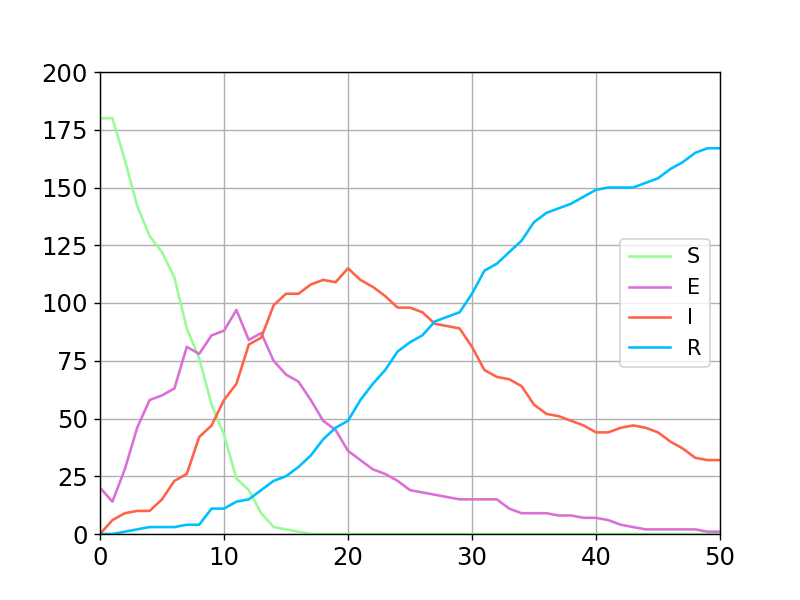

<IPython.core.display.Javascript object>


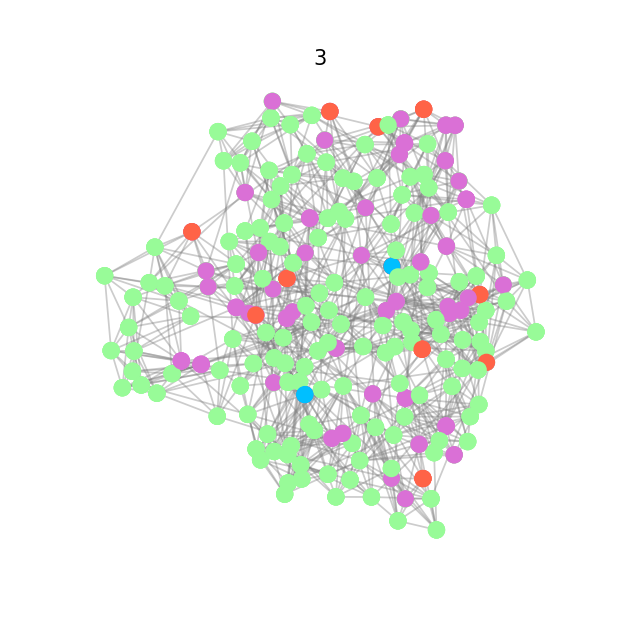

In [167]:
nodes = 200
k = 10
p = 0.2
exposedPerc = 0.1
local = False
timesteps = 50
beta = 0.3
delta = 1/8
gamma = 0.05
plotStates = True
Network = createnetwork(nodes, k, p)
Network = start(Network, exposedPerc, local)
Network = everythingSEIR(Network, timesteps, beta, delta, gamma, plotStates= True)

interval = 500
fig, ax = plt.subplots(figsize = [PL.zoom, PL.zoom])
def animate(i):
    if i == 0:
        ax.cla()
        ax.axis('off')
        nx.draw_networkx_edges(Network['links'], Network['pos'], alpha= PL.edgeAlpha, edge_color= PL.edgeColor, ax= ax)
    nx.draw_networkx_nodes(Network['links'], Network['pos'], node_size= PL.nodeSize, node_color= Network['dataColors'][i], ax= ax)
    ax.set_title(i)
aniSEIR = animation.FuncAnimation(fig, animate, frames= timesteps + 1, repeat= True, interval= interval)
plt.show()

<IPython.core.display.Javascript object>


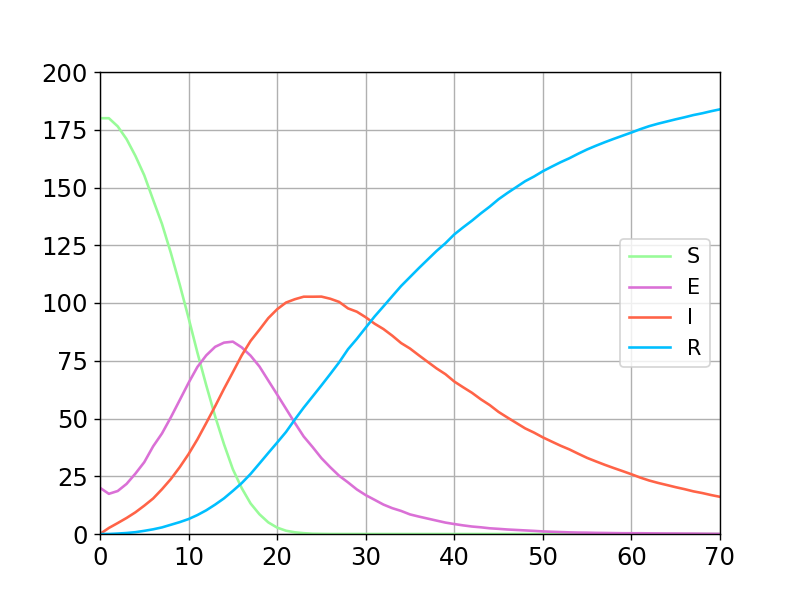

In [58]:
nodes = 200
k = 10
p = 0.2
exposedPerc = 0.1
local = True
timesteps = 70
beta = 0.3
delta = 1/8
gamma = 0.05

N = 100
plotAverage = True
averageS, averageE, averageI, averageR = averageSEIR(nodes, k, p, exposedPerc, timesteps, local, beta, delta, gamma, N, plotAverage)

<IPython.core.display.Javascript object>


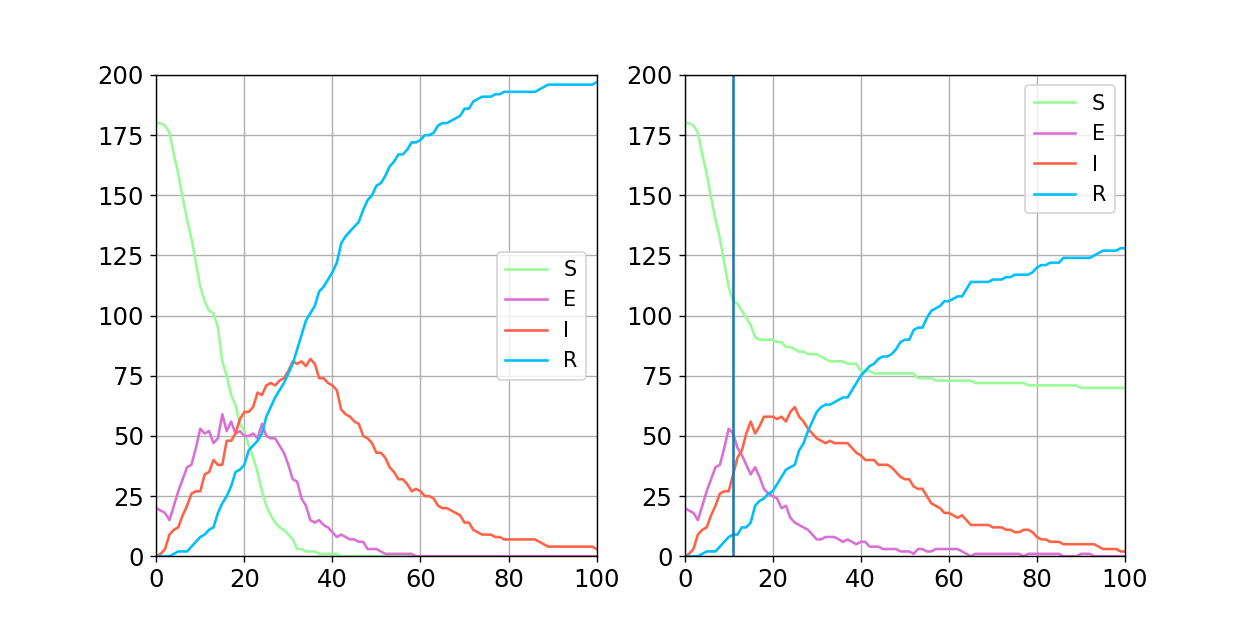

<IPython.core.display.Javascript object>


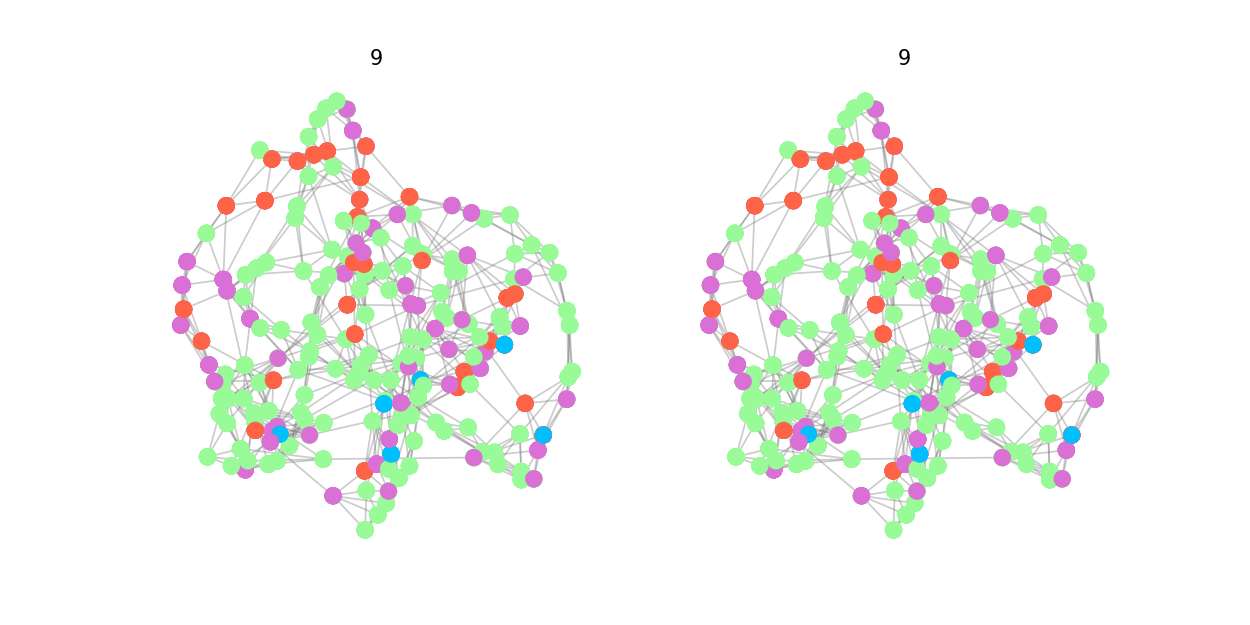

11


In [228]:
nodes = 200
k = 6
p = 0.1
exposedPerc = 0.1
local = False
timesteps = 100
beta = 0.3
delta = 1/8
gamma = 0.05
plotStates = True

socialDistance = True
removePerc = 0.8
socialDistancePerc = 0.15
split= True

Network = createnetwork(nodes, k, p)
Network = start(Network, exposedPerc, local)
Network, originalNetwork = everythingSEIR(Network, timesteps, beta, delta, gamma, plotStates= plotStates, socialDistance= socialDistance, removePerc= removePerc, socialDistancePerc= socialDistancePerc, split= split)

interval = 500
fig, (ax1, ax2) = plt.subplots(nrows= 1, ncols= 2, figsize = [2*PL.zoom, PL.zoom])
def animate(i):
    if i == 0:
        ax1.cla()
        ax1.axis('off')
        nx.draw_networkx_edges(originalNetwork['links'], Network['pos'], alpha= PL.edgeAlpha, edge_color= PL.edgeColor, ax= ax1)
        
        ax2.cla()
        ax2.axis('off')
        nx.draw_networkx_edges(originalNetwork['links'], Network['pos'], alpha= PL.edgeAlpha, edge_color= PL.edgeColor, ax= ax2)
    
    if i == Network['socialDistanceTimestep']:
        ax2.cla()
        ax2.axis('off')
        nx.draw_networkx_edges(Network['links'], Network['pos'], alpha= PL.edgeAlpha, edge_color= PL.edgeColor, ax= ax2)
    nx.draw_networkx_nodes(originalNetwork['links'], Network['pos'], node_size= PL.nodeSize, node_color= originalNetwork['dataColors'][i], ax= ax1)
    nx.draw_networkx_nodes(Network['links'], Network['pos'], node_size= PL.nodeSize, node_color= Network['dataColors'][i], ax= ax2)
    ax1.set_title(i)
    ax2.set_title(i)
aniSEIR = animation.FuncAnimation(fig, animate, frames= timesteps + 1, repeat= True, interval= interval)
plt.show()
print(Network['socialDistanceTimestep'])

<IPython.core.display.Javascript object>


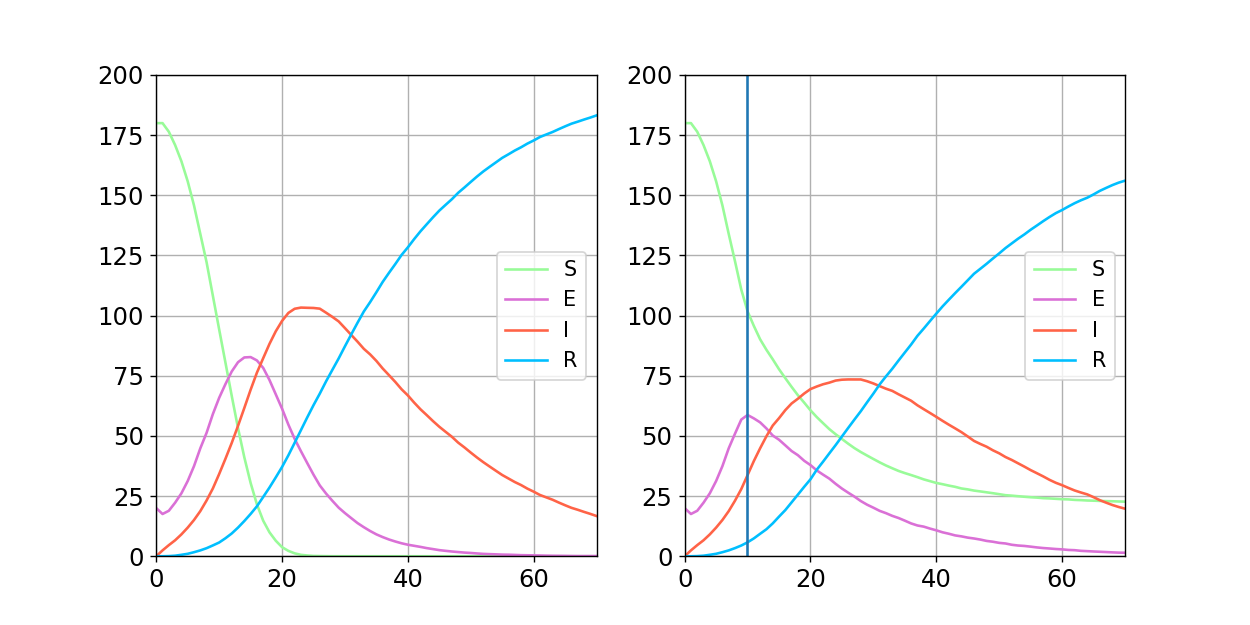

9.92

In [230]:
nodes = 200
k = 10
p = 0.2
exposedPerc = 0.1
local = True
timesteps = 70
beta = 0.3
delta = 1/8
gamma = 0.05

socialDistance = True
removePerc = 0.8
socialDistancePerc = 0.15
split= True

N = 100
plotAverage = True
averageS, averageE, averageI, averageR, averageOriginalS, averageOriginalE, averageOriginalI, averageOriginalR, averageSocialDistanceTimestep = averageSEIR(nodes, k, p, exposedPerc, timesteps, local, beta, delta, gamma, N, plotAverage, socialDistance= socialDistance, socialDistancePerc= socialDistancePerc, removePerc= removePerc, split= split)
averageSocialDistanceTimestep